In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, 
    precision_score, recall_score, f1_score
)

In [2]:
# import data
card = pd.read_csv('data/kaggle/CardBase.csv')
customer = pd.read_csv('data/kaggle/CustomerBase.csv')
fraud = pd.read_csv('data/RAND_FraudBase.csv')
transaction = pd.read_csv('data/kaggle/TransactionBase.csv')

## TASK 1

*Writing a function that filters and aggregates data by card family and customer segment, based on a date and customer age range. Function is called for age 28-44 and date May 10th - Jul 16th (inclusive) below.*

In [3]:
def filter_summarize_transactions(min_age, max_age, start_date, end_date):
    """
    Takes an age range and date range and returns a data frame
    with the ount, mean, and standard deviation of the transaction amounts 
    by card family and customer segment, limited to the inputted ranges.

    Arguments: 
        min_age (int): Lower bound for age range
        max_age (int): Upper bound for age range
        start_date (date): Lower bound date age range
        end_date (date): Upper bound date age range
    """
    # merge transaction data with card data (on Card_Number and Credit_Card_ID) and customer data (on Cust_ID)
    merged = transaction.merge(card, left_on='Credit_Card_ID', right_on='Card_Number').merge(customer, on='Cust_ID')

    # convert date to datetime type for comparison
    merged['Transaction_Date1'] = pd.to_datetime(merged.Transaction_Date, format='%d-%b-%y')

    # filter data for the given date and age range
    filtered = (merged.loc[(merged.Age>=min_age) & (merged.Age<=max_age)]
                      .loc[(merged.Transaction_Date1>=start_date) & (merged.Transaction_Date1<=end_date)])

    # group by/aggregate for count, mean, and standard deviation of transaction values
    grouped = filtered.groupby(['Card_Family', 
                                'Customer_Segment']).agg({'Transaction_Value': ['count', 'mean', 'std']}).reset_index()
    
    return grouped

In [4]:
# displaying results of calling the function for age 28-44 and date May 10th - Jul 16th (inclusive)
start_date = pd.to_datetime('10-May-2016', format='%d-%b-%Y')
end_date = pd.to_datetime('16-Jul-2016', format='%d-%b-%Y')
result = filter_summarize_transactions(min_age=28, max_age=44, 
                                       start_date=start_date, end_date=end_date)
display(result)

Card_Family Customer_Segment Transaction_Value                            
                                           count          mean           std
0        Gold          Diamond               159  25947.490566  14295.469532
1        Gold             Gold               110  24850.972727  13211.350331
2        Gold         Platinum                60  22826.933333  14499.972092
3    Platinum          Diamond                91  23105.197802  13891.667734
4    Platinum             Gold                65  24459.815385  13725.743636
5    Platinum         Platinum                65  24620.600000  14958.461580
6     Premium          Diamond               195  23435.748718  15538.776861
7     Premium             Gold               136  23741.492647  14526.895788
8     Premium         Platinum                93  25273.182796  14595.783222

## TASK 2

*Building a logistic regression model using the statsmodels package to predict fraud using transaction value, value as a share of limit, age, card family, customer segment, and transaction segment; no cross validation.*

In [5]:
# merge datasets
data = (transaction.merge(card, how='left', left_on='Credit_Card_ID', right_on='Card_Number')
                   .merge(customer, how='left', on='Cust_ID')
                   .merge(fraud, how='left',  on='Transaction_ID'))
data.Fraud_Flag = data.Fraud_Flag.fillna(0)

# create value as share of limit variable
data['Limit_Share'] = data['Transaction_Value'] / data['Credit_Limit']

The results of a logistic model using transaction value, credit limit share, age, card family, customer segment, and transaction segment are displayed below. 

Here are a few takeaways from this model:

- There are likely other factors that should be accounted for in predicting fraud. The *R-squared value* of 0.1687 suggests that only about 16.87% of the variability in the fraud variable can be explained by the model. 
- Higher *credit limit share* values are associated with increased odds of fraud, by about 6% (exp(0.0595)) per unit of increase in limit share. This coefficient is statistically significant (p<0.001).
- In terms of *age*, a statistically significant positive coefficient (p<0.1) suggests that for each additional year of age, the odds of being associated with a fradulent transaction increases by about 0.8%.
- In terms of *card family*, compared to the gold family, platinum card transactions are associated with lower odds of being fraudulent by 96% (statistically significant with p<.001) while premium card transactions are associated with substantially higher odds of being fraudulent by 227% (p<.001).
- In terms of *customer segment*, compared to the diamond group, gold customer transactions are associated with lower odds of being fraud by about 17% (p<.001). The platinum segment coefficient is not statistically significant, suggesting no strong difference in odds.
- Finally, none of the *transaction segment* coefficients are statistically significiant, indicating that these segments are not helpful indicators in predicting the likelihood of fraud.

In [6]:
# fitting logstic regression with statsmodels package

# define X and y
X = data[['Transaction_Value', 'Limit_Share', 'Age', 'Card_Family', 'Customer_Segment', 'Transaction_Segment']]
X = pd.get_dummies(data=X, drop_first=True)
y = data['Fraud_Flag']

X = sm.add_constant(X)

model = sm.Logit(y, X.astype(float)).fit(disp=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Fraud_Flag   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9978
Method:                           MLE   Df Model:                           21
Date:                Mon, 30 Dec 2024   Pseudo R-squ.:                  0.1687
Time:                        15:01:44   Log-Likelihood:                -4849.3
converged:                       True   LL-Null:                       -5833.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.6552      0.156    -10.589      0.000      -1.962      -1.349
Transaction_Value          2.497e-06   1.76e-06      1.423      0.155   -9.43e-07    5.94e-06
Limit_Share                   0.0595      0.016      3.826      0.000       0.029       0.090
Age                           0.0080      0.003      2.831      0.005       0.002       0.014
Card_Family_Platinum         -3.2879      0.219    -14.995      0.000      -3.718      -2.858
Card_Family_Premium           1.1844      0.057     20.709      0.000       1.072       1.297
Customer_Segment_Gold        -0.1900      0.057     -3.357      0.001      -0.301      -0.079
Customer_Segment_Platinum    -0.0230      0.064     -0.360      0.719      -0.148       0.102
Transaction_Segment_SEG12     0.0733      0.133      0.550      0.582      -0.188       0.334
Transaction_Segment_SEG13    -0.0018      0.134     -0.014      0.989      -0.265       0.261
Transaction_Segment_SEG14    -0.0515      0.138     -0.372      0.710      -0.322       0.219
Transaction_Segment_SEG15     0.0737      0.133      0.552      0.581      -0.188       0.335
Transaction_Segment_SEG16    -0.2070      0.138     -1.501      0.133      -0.477       0.063
Transaction_Segment_SEG17     0.0573      0.135      0.426      0.670      -0.207       0.321
Transaction_Segment_SEG18    -0.1205      0.135     -0.892      0.372      -0.385       0.144
Transaction_Segment_SEG19    -0.1516      0.138     -1.096      0.273      -0.423       0.120
Transaction_Segment_SEG20     0.2471      0.132      1.870      0.061      -0.012       0.506
Transaction_Segment_SEG21     0.0630      0.135      0.467      0.641      -0.202       0.328
Transaction_Segment_SEG22     0.0428      0.135      0.316      0.752      -0.222       0.308
Transaction_Segment_SEG23     0.0966      0.133      0.729      0.466      -0.163       0.356
Transaction_Segment_SEG24     0.1300      0.134      0.969      0.333      -0.133       0.393
Transaction_Segment_SEG25    -0.0274      0.136     -0.201      0.841      -0.294       0.239
=============================================================================================
"""

## TASK 3

*Implementing a lightGBM and logistic regression classification algorithm using scikit-learn to predict fraud using Transaction Value, Credit Limit, Age, and Card Family as features/predictors with 80/20 cross validation. Transactions calssified as fraud if they have a greater than 0.25 (25%) predicted probability.*

In [7]:
# Train/test split

# define data
model_data = data[['Fraud_Flag', 'Transaction_Value', 
                   'Credit_Limit', 'Age', 'Card_Family']]
model_data = pd.get_dummies(model_data, columns=['Card_Family'], drop_first=True)

# split data
X = model_data.drop('Fraud_Flag', axis=1)
y = model_data['Fraud_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

### Model 1: LGBM

In [8]:
# fit model
lgbm_model = LGBMClassifier(random_state=54, verbosity=-1)
lgbm_model.fit(X_train, y_train)

# get predictions
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]
lgbm_preds = (lgbm_probs > 0.25).astype(int)

# get metrics
lgbm_cm = confusion_matrix(y_test, lgbm_preds)
lgbm_cr = classification_report(y_test, lgbm_preds, output_dict=True)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
lgbm_precision = precision_score(y_test, lgbm_preds)
lgbm_recall = recall_score(y_test, lgbm_preds)
lgbm_f1 = f1_score(y_test, lgbm_preds)

For this task, I chose to implement a LightGBM classification model. The confusion matrix and classification report for the LGBM model are displayed below. The AUC score for this model is `{python} round(lgbm_auc,3)`.

In [9]:
# LGBM confusion matrix
lgbm_cm_df = pd.DataFrame(lgbm_cm)
lgbm_cm_df.columns = ['pred_0','pred_1']
lgbm_cm_df.index = ['actual_0','actual_1']
display(lgbm_cm_df)

# LGBM classification report
display(pd.DataFrame(lgbm_cr))

,pred_0,pred_1
actual_0,1007,463
actual_1,134,396


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.882559,0.461001,0.7015,0.671780,0.770846
recall,0.685034,0.747170,0.7015,0.716102,0.701500
f1-score,0.771352,0.570194,0.7015,0.670773,0.718045
support,1470.000000,530.000000,0.7015,2000.000000,2000.000000


### Model 2: Logistic Regression

In [10]:
# fit model
log_reg_model = LogisticRegression(max_iter=1000, random_state=54)
log_reg_model.fit(X_train, y_train)

# get predictions
log_probs = log_reg_model.predict_proba(X_test)[:, 1]
log_preds = (log_probs > 0.25).astype(int)

# get metrics
log_cm = confusion_matrix(y_test, log_preds)
log_cr = classification_report(y_test, log_preds,output_dict=True)
log_auc = roc_auc_score(y_test, log_probs)
log_precision = precision_score(y_test, log_preds)
log_recall = recall_score(y_test, log_preds)
log_f1 = f1_score(y_test, log_preds)

The confusion matrix and classification report for the logit model are displayed below. The AUC score for this model is `{python} round(log_auc,3)`.

In [11]:
# logit confusion matrix
log_cm_df = pd.DataFrame(log_cm)
log_cm_df.columns = ['pred_0','pred_1']
log_cm_df.index = ['actual_0','actual_1']
display(log_cm_df)

# logit classification report
display(pd.DataFrame(log_cr))

,pred_0,pred_1
actual_0,1098,372
actual_1,177,353


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.861176,0.486897,0.7255,0.674037,0.761992
recall,0.746939,0.666038,0.7255,0.706488,0.725500
f1-score,0.800000,0.562550,0.7255,0.681275,0.737076
support,1470.000000,530.000000,0.7255,2000.000000,2000.000000


### Metric evaluation table

The table below summarizes the evaluation metrics for the lgbm and logistic models.

In [12]:
# metrics table
metrics = pd.DataFrame(
    {
        'metric': ['precision', 'recall', 'f1', 'auc', 
                   'true negative', 'false positive',
                   'false negative', 'true positive'],
         'lgbm': [lgbm_precision, lgbm_recall, 
                  lgbm_f1, lgbm_auc,
                  lgbm_cm[0][0], lgbm_cm[0][1], 
                  lgbm_cm[1][0], lgbm_cm[1][1]],
         'logistic': [log_precision, log_recall,
                      log_f1, log_auc,
                      log_cm[0][0], log_cm[0][1], 
                      log_cm[1][0], log_cm[1][1]]
    }
)
metrics

,metric,lgbm,logistic
0,precision,0.461001,0.486897
1,recall,0.747170,0.666038
2,f1,0.570194,0.562550
3,auc,0.811617,0.787994
4,true negative,1007.000000,1098.000000
5,false positive,463.000000,372.000000
6,false negative,134.000000,177.000000
7,true positive,396.000000,353.000000


### Metric evaluation plots

Below the ROC and precision-recall curves for the lgbm and logistic models are displayed.

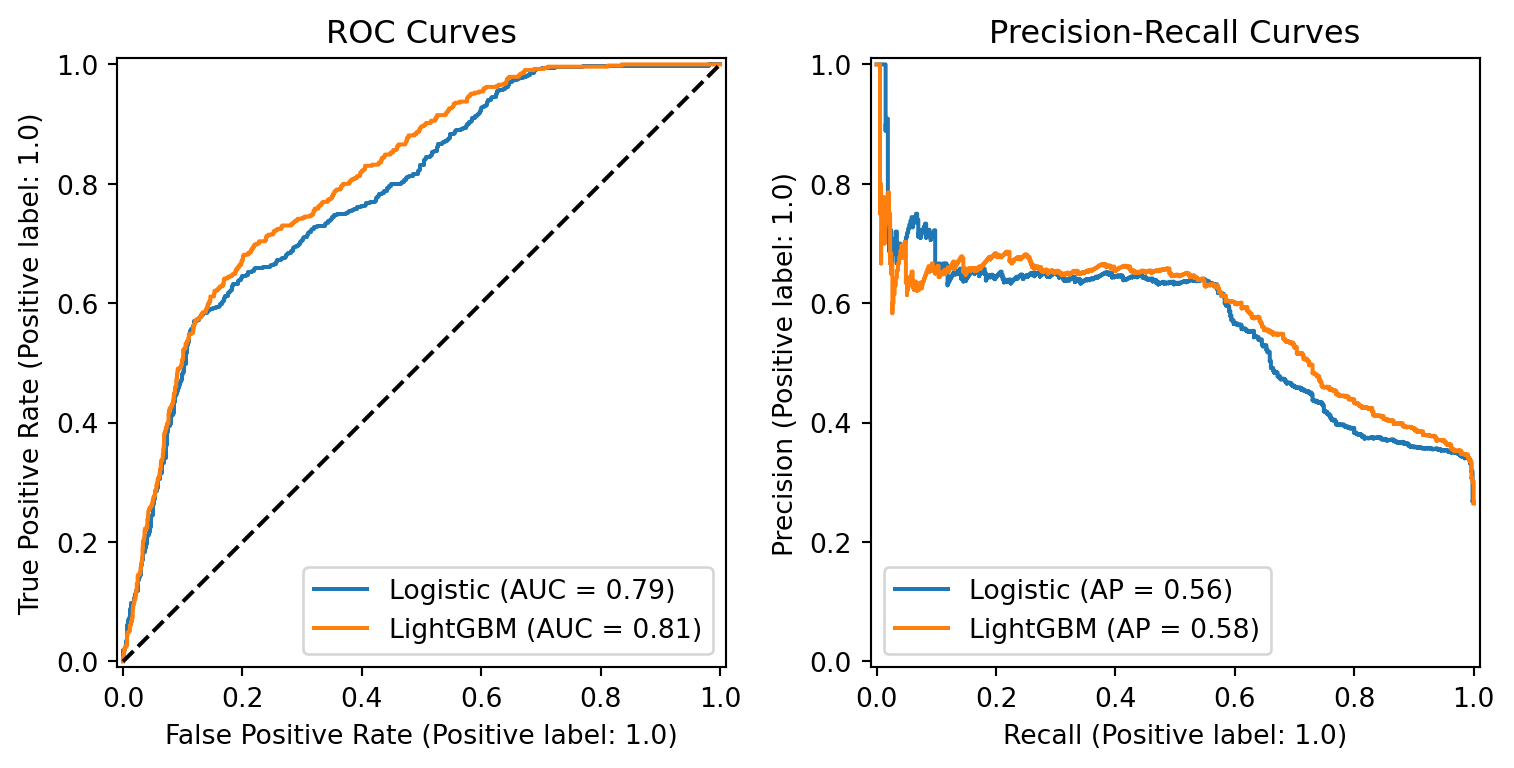

In [13]:
# plot ROC and precision-recall curves

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ROC curves
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax1, name='Logistic')
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax1, name='LightGBM')
ax1.set_title('ROC Curves')
ax1.plot([0, 1], [0, 1], 'k--')  # diagonal line for reference of random model

# Precision-recall curves
PrecisionRecallDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax2, name='Logistic')
PrecisionRecallDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax2, name='LightGBM')
ax2.set_title('Precision-Recall Curves')

plt.tight_layout()
plt.show()

## TASK 4

### Model comparison

Based on my analysis, I conclude that a LightGBM model would be preferable over a logistic regression model in a production setting.

It is important to note that I assume a credit card company's primary goal is to minimize false negatives and prioritize recall over precision. Missing actual fraudulent cases would be much more costly than falsely flagging legitimate transactions. While false alarms can inconvenience customers, this is of lower priority than overlooking fraud, which would result in financial losses and reputational damage.

My conclusion is supported by the metrics table and plots above:

- The LGBM model has a substantially higher *recall* score (0.75) than the logistic model (0.67), meaning that the LGBM model is able to capture a significant portion of fraudulent transactions.
- While the logistic model has higher *precision* (0.49) than the lgbm model (0.46), this difference is negligible compared to the significant difference in recall.
- The *precision-recall graph* visualizes the difference in precision and recall between the two models. The LGBM curve is slightly higher and pulled to the right, signifying that it outperforms the logistic model.
- The *F1 scores* are similar, with the LGBM model scoring slightly higher (.57 vs .56), suggesting both models are able to balance precision and recall.
- The LGBM model also has a slightly higher *AUC score* (.81 vs. .79), indicating the LGBM model is more accurate at distinguishing between the two classes. The *ROC curves* visualize this, showing that for different classification thresholds, the LGBM model has better sensitivity and specificity on average.
- Looking at the numbers more closely, the LGBM model is able to identify more true positives (396 vs 353 out of 530 total fraud cases). While the logistic model is able to limit more false positives (372 vs 463), I believe the LGBM's better ability to identify fraud makes it the better model for this setting. 

Finally, LGBM is the better model in terms of large-scale performance and scalability. A fraud classifier would have to handle a significant amount of data, with millions of users and transactions. LGBM models [outperform](https://www.nature.com/articles/s41598-022-20149-z?utm_source=chatgpt.com) logistic models and improve with larger sample sizes and datasets. They have superior speed and efficiency, and exhibit efficient resource utilization even as datasets grow. 

To limit the false positive rate and improve customer satisfaction, I would recommend adjusting the decision threshold for classifying fraud cases, implementing additional verification steps for flagged transactions, and developing user-friendly methods for customers to verify whether flagged transactions are actually fraudulent.

### Experiment recommendation 

The program described could be implemented as a randomized controlled trial. To determine whether the anti-fraud program is effective, I suggest the following strategy:

1. Collect data over a minimum of 12-18 months to allow for enough time to detect fraudulent patterns and account for seasonal/holiday variations.
2. Collect all transaction information, including ID, date, merchant description, credit card information, amount, and whether the transaction was fraudulent.
3. Collect customer information, such as age, education level, credit score, income level, and residence zip code.
4. Collect information on outcome variables that indicate whether the program was effective. This includes the number of fraud cases, the company's financial losses due to fraud, customer complaints due to falsely flagged transactions, and the operational costs associated with the anti-fraud program, such as implementation or resource utilization. The company can also consider implementing surveys to gauge program impact on customer satisfaction.
5. Implement a series of regression models to analyze the differences in outcomes between treatment and control groups. The outcome variables would include financial losses, number of fraudulent cases, and customer satisfaction. The independent variable with the coefficient of interest is whether the transaction was treated with the anti-fraud program, and the remainder of the variables will serve as control variables.
6. Use the findings from the control variables to continually improve on the anti-fraud program. For example, the model may indicate that more fraudulent transactions occur during the holiday season, in particular zip codes, or higher age ranges. 

In order for the program to be deemed as effective, there would need to be a statistically significant treatment effect indicating that cases in the anti-fraud program were associated with less financial losses, less fraudulent cases, and better customer satisfaction. Because this is a randomized controlled trial, the treatment effect could be interpreted as a direct causal effect of the program. Importantly, these results should be substantial enough to outweigh the recorded operational costs of the program. 